In [41]:
import pandas as pd
import json
import requests
import warnings
from matplotlib import pyplot as plt
import matplotlib
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
%matplotlib inline
from IPython.display import IFrame
import re
import numpy

font = {'family' : 'helvetica',
        'size'   : 22}

matplotlib.rc('font', **font)

# Cuomo Campaign Contributions from Board of Elections

I read the CSV, then I take the dollar signs out of the 'Amount' column, ...and convert it to float so I can do calculations.

I convert the 'Date' column to Pandas datetime, so I can sort and filter by date.

In [42]:
df = pd.read_csv("Campaign_Contributions.csv")
ftm_df = pd.read_csv("FollowTheMoneyDownload20180705(010706).csv")
ftm_df = ftm_df.drop_duplicates('Original_Name', keep='first')
df['Amount'] = df['Amount'].replace( '[\$,)]','', regex=True ).astype(float)
new_df = pd.merge(df, ftm_df, left_on='Donor', right_on='Original_Name', how='left', suffixes=['_boe','_ftm'])

## FollowTheMoney has data on individual donors, but they aggregate donations.

So I am going to use their data, combined with Board of Elections donations

In [43]:
new_df['Date'] = pd.to_datetime(new_df['Date_boe'], infer_datetime_format=True)
new_df['Donation_Date']=new_df['Date']
new_df.set_index('Date', inplace=True)
new_df.sort_index(axis=0, inplace=True)
new_df.dropna(subset=['Date_boe'], inplace=True)

In [44]:
new_df = new_df[['Donor', 'Address', 'Filer ID', 'Check No.', 'Amount_boe', 'Date_boe',
       'Recipient', 'Transaction Code', 'Contribution Code',
       'Contribution Type', 'Fiscal Report', 'request',
       'Filing_Jurisdiction', 'Filer',
       'Candidate',
       'Candidate_Entity',
       'Election_Status',
       'Status_of_Candidate',
       'Specific_Party',
       'General_Party', 'Election_Jurisdiction',
       'Election_Year',
       'Election_Type',
       'Original_Name',
       'Contributor',
       'Type_of_Contributor','Specific_Business', 'General_Industry','Broad_Sector',
       'Amount_ftm', 'Date_ftm','Type_of_Transaction','Purpose','City','State','Zip', 'In-State',
       'Parent_Org_or_Employer', 'Donation_Date']]

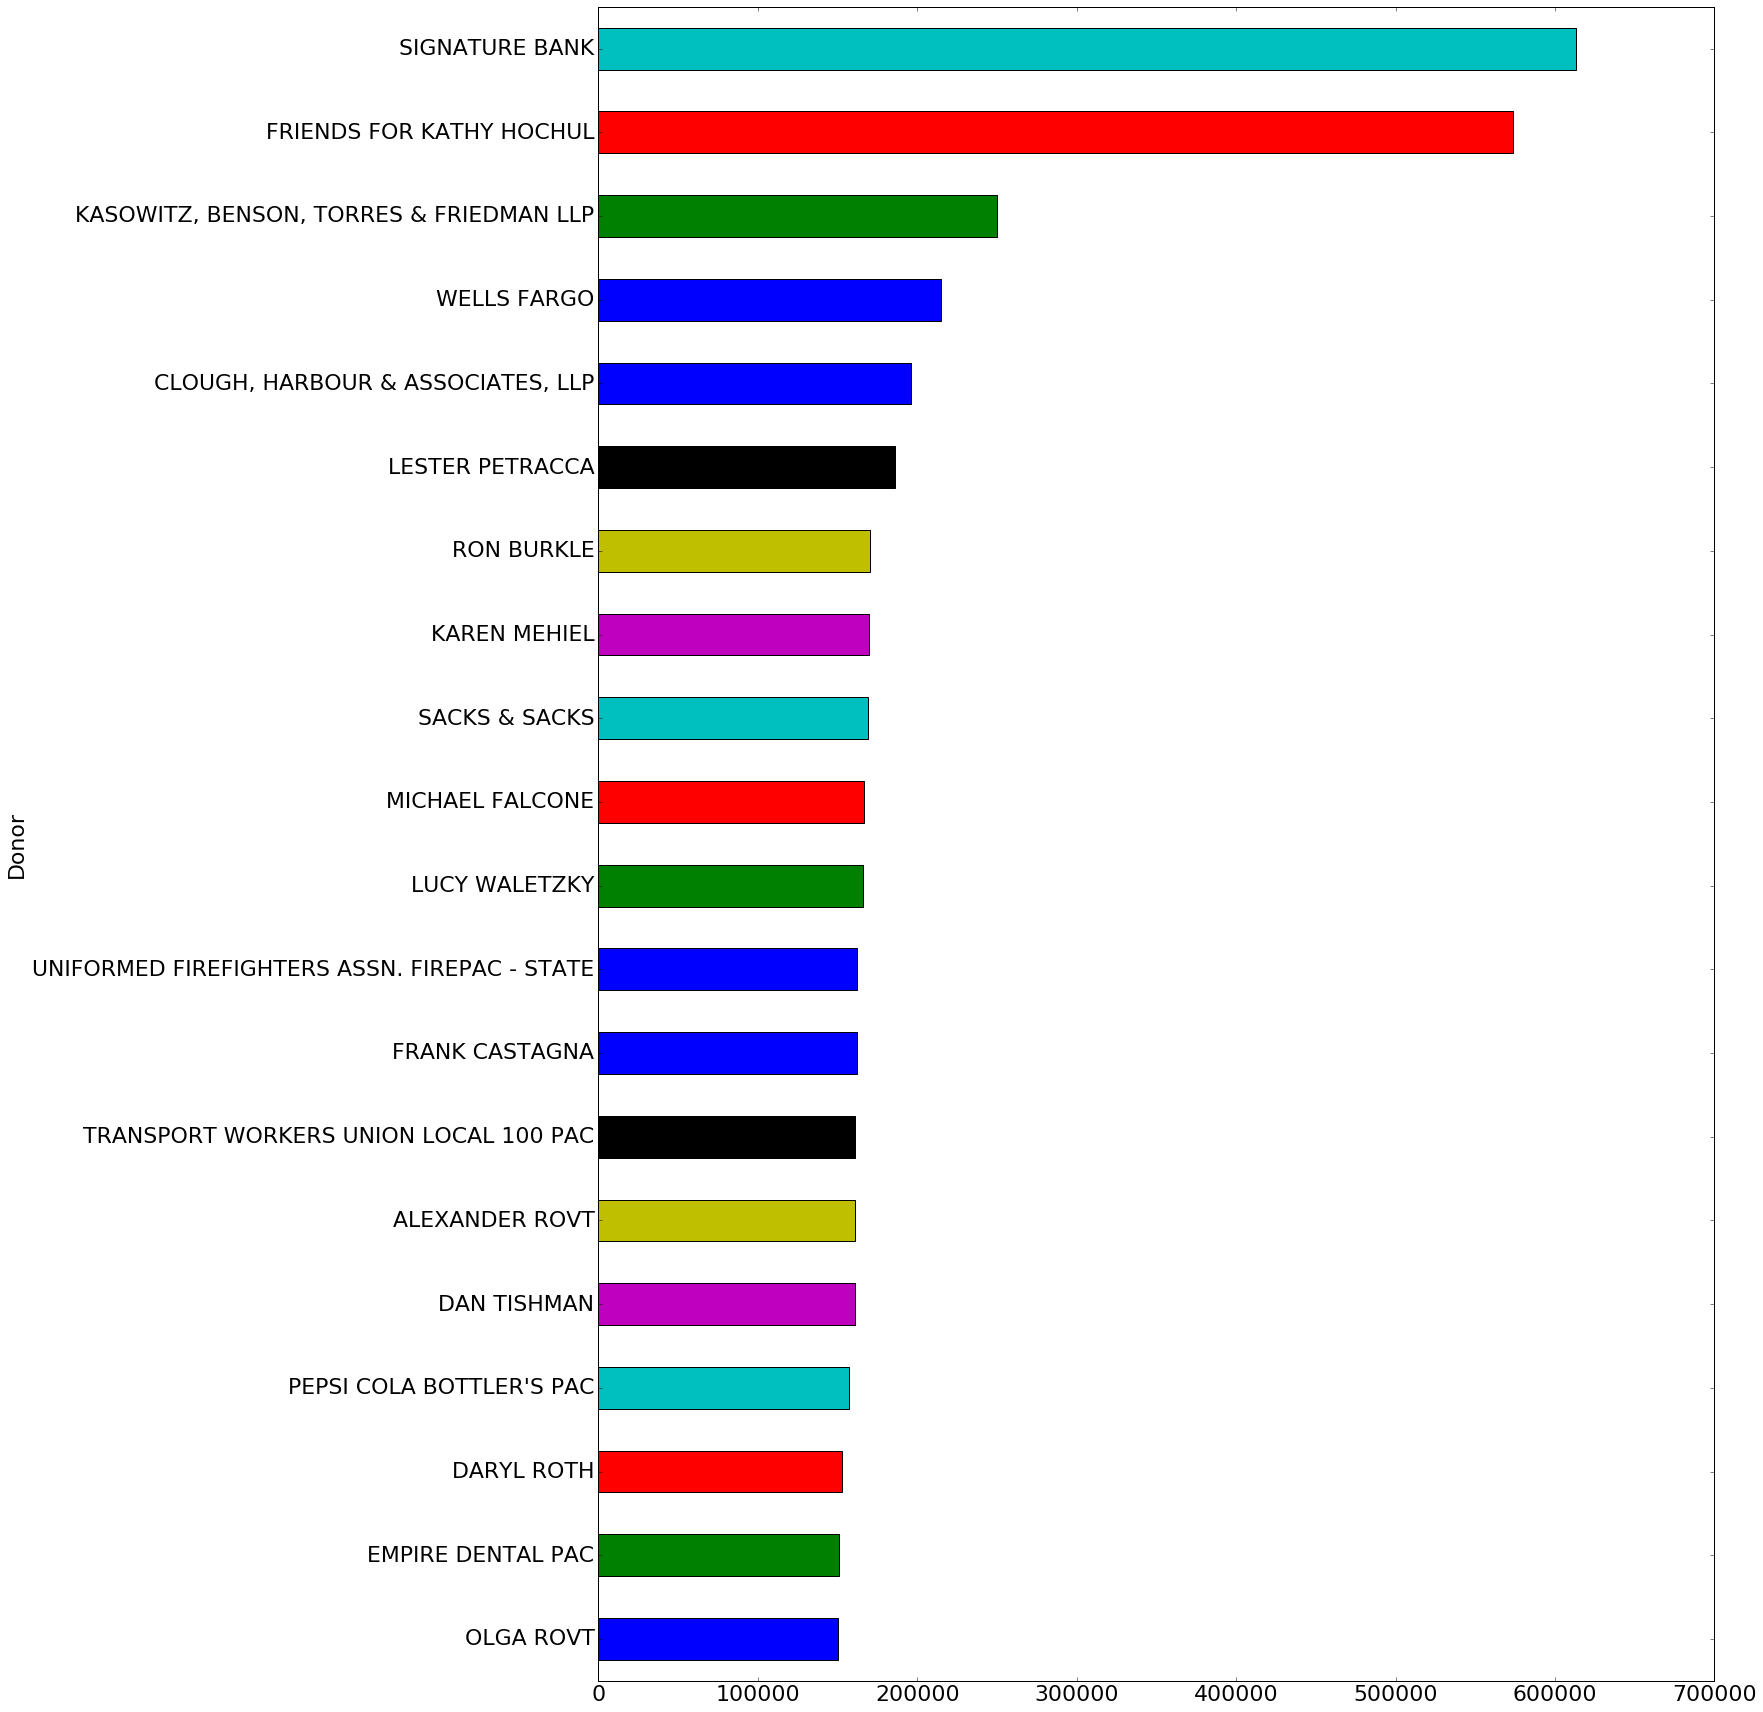

In [45]:
plt.figure(figsize=(20,30))
new_df['2010-01-01':].groupby('Donor').filter(lambda x: x['Amount_boe'].sum()>150000)\
.groupby('Donor')['Amount_boe'].sum().sort_values().plot(kind='barh')

## Notable donors include:
*Signature bank*
- Ivanka Trump is on the board of directors
- Barney Frank is on the board of directors
- Ron Wasserman is an "associate group director", and is a member of AIPAC and chairman of Fuel for Truth, an anti-muslim think tank-funded org

*Kathy Hochul*
- Lieutenant governor of NYS
- "Friends for Kathy Hochul" receives money from LLC's, donates to Cuomo
- Kathy Hochul is heavily invested in the oil industry

*Kasowitz Benson Torres Friedman LLP*
- major RNC donor ($251,900)
- Trump donor
- https://projects.propublica.org/trump-town/organizations/kasowitz-benson-torres-friedman-llp !!!

In [46]:
IFrame('https://littlesis.org/maps/2780-kathy-hochul-s-fossil-fuel-investments/embedded/v2', width=700, height=350, scrolling='no')

## "Governor Glenwood" indeed!

In [47]:
print("Over the years, Glenwood has given", new_df[new_df['Parent_Org_or_Employer'].str.contains("GLENWOOD", na=False)]['Amount_boe'].sum(), "to Cuomo's campaign.")

Over the years, Glenwood has given 889400.0 to Cuomo's campaign.


In [48]:
#EDIT: John and Peter want to look at everything from 2010 onward.
df_warchest = new_df['2010-01-01':]
df_warchest.columns

Index(['Donor', 'Address', 'Filer ID', 'Check No.', 'Amount_boe', 'Date_boe',
       'Recipient', 'Transaction Code', 'Contribution Code',
       'Contribution Type', 'Fiscal Report', 'request', 'Filing_Jurisdiction',
       'Filer', 'Candidate', 'Candidate_Entity', 'Election_Status',
       'Status_of_Candidate', 'Specific_Party', 'General_Party',
       'Election_Jurisdiction', 'Election_Year', 'Election_Type',
       'Original_Name', 'Contributor', 'Type_of_Contributor',
       'Specific_Business', 'General_Industry', 'Broad_Sector', 'Amount_ftm',
       'Date_ftm', 'Type_of_Transaction', 'Purpose', 'City', 'State', 'Zip',
       'In-State', 'Parent_Org_or_Employer', 'Donation_Date'],
      dtype='object')

In [49]:
#These are some entities that I know are Real Estate donors: Fisher Brothers, and Brookfield Properties, NORSTAR.
#May 18, 2017, Cuomo announces renewal of 421a. One day later, May 19, 2017, he receives 159,000
#I see that Brookfield donated 40,000 on January 9, 2017, and another 150,000 this year on the same date.
#What has Cuomo done to help Brookfield?
#Cablevision has given to Cuomo under many, many different names. I got this list from the SEC.

df_warchest.loc[df_warchest['Donor'].str.contains("FISHER BROTHERS", na=False), 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Donor'].str.contains("FISHER BROTHERS", na=False), 'Parent_Org_or_Employer']='Fisher Brothers'
df_warchest.loc[df_warchest['Address']=='FL 42 299 PARK AVE NEW YORK, NY, 10171', 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Address']=='FL 42 299 PARK AVE NEW YORK, NY, 10171', 'Parent_Org_or_Employer']='Fisher Brothers'

df_warchest.loc[df_warchest['Donor'].str.contains("BOP", na=False), 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'
df_warchest.loc[df_warchest['Donor'].str.contains("BOP", na=False), 'Parent_Org_or_Employer']='Brookfield'

df_warchest.loc[df_warchest['Donor'].str.contains("CLOUGH, HARBOUR", na=False), 'Parent_Org_or_Employer']='Longpoint Capital'
df_warchest.loc[df_warchest['Donor'].str.contains("CLOUGH, HARBOUR", na=False), 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'

df_warchest.loc[((df_warchest['General_Industry'] == 'Uncoded') & (df_warchest['Donor'].str.contains("NORSTAR"))), 'General_Industry']='Real Estate'

df_warchest.loc[df_warchest['Donor'].str.contains("REXSCOTT", na=False), 'Parent_Org_or_Employer']='RXR Realty'
df_warchest.loc[((df_warchest['General_Industry'] == 'Uncoded') & (df_warchest['Donor'].str.contains("REXSCOTT"))), 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Donor'].str.contains("RXR", na=False), 'Parent_Org_or_Employer']='RXR Realty'

df_warchest.loc[df_warchest['Donor'].str.contains(r"\bSTV\b", na=False), 'Parent_Org_or_Employer']='STV Incorporated'
df_warchest.loc[df_warchest['Donor']=="STV", 'General_Industry']='Construction Services'
df_warchest.loc[df_warchest['Donor']=="STV", 'Parent_Org_or_Employer']='STV Incorporated'

df_warchest.loc[df_warchest['Address']=='205 W WELSH DR DOUGLASSVILLE, PA, 19518', 'Parent_Org_or_Employer'] = 'STV Incorporated'
df_warchest.loc[df_warchest['Address']=='205 W WELSH DR DOUGLASSVILLE, PA, 19518', 'General_Industry']='Construction Services'

df_warchest.loc[df_warchest['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'Parent_Org_or_Employer']='Nixon Peabody LLP'
df_warchest.loc[df_warchest['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'General_Industry']='Lawyers & Lobbyists'

cablevision_list = ["1015 TIFFANY STREET",
"1047 E 46TH STREET",
"111 NEW SOUTH ROAD",
"1111 STEWART",
"1144 ROUTE 109 CORP.",
"151 S. FULTON STREET",
"2234 FULTON STREET",
"389 ADAMS STREET",
"4CONNECTIONS",
"A-R CABLE SERVICES - NY",
"BBHI HOLDINGS",
"CABLEVISION DISASTER RELIEF FUND",
"CABLEVISION",
"CABLEVISION MEDIA SALES",
"CABLEVISION NYI",
"CABLEVISION OF BROOKHAVEN",
"CABLEVISION OF HUDSON COUNTY",
"CABLEVISION OF MONMOUTH",
"CABLEVISION OF NEW JERSEY",
"CABLEVISION OF NEWARK",
"CABLEVISION OF OAKLAND",
"CABLEVISION OF OSSINING",
"Cablevision of Ossining",
"CABLEVISION OF PATERSON",
"Cablevision of Allamuchy",
"CABLEVISION OF ROCKLAND/RAMAPO",
"CABLEVISION OF SOUTHERN WESTCHESTER",
"CABLEVISION OF WAPPINGERS FALLS",
"CABLEVISION OF WARWICK",
"CABLEVISION REAL ESTATE",
"CABLEVISION SYSTEMS BROOKLINE",
"CABLEVISION SYSTEMS DUTCHESS",
"CABLEVISION SYSTEMS EAST HAMPTON",
"CABLEVISION SYSTEMS GREAT NECK",
"CABLEVISION SYSTEMS HUNTINGTON",
"CABLEVISION SYSTEMS ISLIP",
"CABLEVISION SYSTEMS",
"CABLEVISION SYSTEMS NEW YORK CITY",
"CABLEVISION SYSTEMS SUFFOLK",
"CABLEVISION SYSTEMS WESTCHESTER",
"CCG HOLDINGS",
"Clearview Cinemas",
"CORAM ROUTE 112",
"CSC ACQUISITION - MA",
"CSC ACQUISITION - NY",
"CSC ACQUISITION",
"CSC GATEWAY",
"CSC INVESTMENTS",
"CSC MVDDS",
"CSC NASSAU II",
"CSC OPTIMUM HOLDINGS",
"CSC T HOLDINGS I",
"CSC T HOLDINGS II",
"CSC T HOLDINGS III",
"CSC T HOLDINGS IV",
"CSC TECHNOLOGY",
"CSC TKR",
"Cablevision of Morris",
"Cablevision of Hamilton",
"Cablevision of Raritan Valley",
"Cablevision of Elizabeth",
"CSC TRANSPORT II",
"CSC TRANSPORT III",
"CSC TRANSPORT",
"CSC VT",
"DTV NORWICH",
"Clearband",
"FROWEIN ROAD",
"LIGHTPATH VOIP",
"MSG VARSITY NETWORK",
"MSG Varsity Network",
"MSGVN",
"N12N",
"NEWS 12 COMPANY",
"News 12",
"NEWS 12 CONNECTICUT",
"News 12 Connecticut of Delaware",
"NEWS 12 HOLDING",
"News 12 Holding of Delaware",
"NEWS 12 II HOLDING",
"NEWS 12 INTERACTIVE",
"News 12 Interactive of Delaware",
"NEWS 12 NETWORKS",
"NEWS 12 NEW JERSEY HOLDING",
"NEWS 12 NEW JERSEY II HOLDING",
"NEWS 12 NEW JERSEY",
"NEWS 12 THE BRONX HOLDING",
"NEWS 12 THE BRONX",
"NEWS 12 TRAFFIC AND WEATHER",
"NEWS 12 WESTCHESTER",
"News 12 Westchester of Delaware",
"NEWSDAY HOLDINGS",
"NEWSDAY",
"NMG HOLDINGS",
"NY OV ",
"PETRA CABLEVISION CORP.",
"PRINCETON VIDEO IMAGE ISRAEL",
"PVI HOLDINGS",
"PVI PHILIPPINES",
"PVI VIRTUAL MEDIA SERVICES",
"RAINBOW MVDDS COMPANY",
"RASCO HOLDINGS",
"RMVDDS",
"OMGFAST!",
"SAMSON CABLEVISION CORP.",
"SUFFOLK CABLE",
"SUFFOLK CABLE OF SHELTER ISLAND",
"SUFFOLK CABLE OF SMITHTOWN",
"TELERAMA",
"THE NEW YORK INTERCONNECT",
"TRISTATE DIGITAL GROUP",
"WIFI CT-NJ",
"WIFI NY"]
#https://www.sec.gov/Archives/edgar/data/784681/000162828016011667/cvc-12312015xex21.htm
for shell in cablevision_list:    
    df_warchest.loc[df_warchest['Donor'].str.contains(shell, re.IGNORECASE, na=False), 'Parent_Org_or_Employer']='Cablevision Systems'
    

In [52]:
rec_df=df_warchest['2017-01-01':]
rec_df[rec_df['General_Industry'] == 'Uncoded'].groupby('Date_boe')['Amount_boe'].sum().sort_values(ascending=False)
rec_df[(rec_df['Date_boe']=='12/13/2017') & (rec_df['General_Industry']=='Uncoded')]
rec_df[rec_df['Donor'].str.contains("PROJECT COMPASSION", na=False)]

,Donor,Address,Filer ID,Check No.,Amount_boe,Date_boe,Recipient,Transaction Code,Contribution Code,Contribution Type,...,Amount_ftm,Date_ftm,Type_of_Transaction,Purpose,City,State,Zip,In-State,Parent_Org_or_Employer,Donation_Date
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-13,PROJECT COMPASSION NY LLC,"STE 146 11315 RANCHO BERNARDO RD SAN DIEGO, CA, 92127",A31966,Wire Trans,50000.0,12/13/2017,ANDREW CUOMO 2018 INC.,Monetary Contributions/All Other,NaN,NaN,...,50000.0,2017-12-13,DIR,NaN,SAN DIEGO,CA,92127.0,0.0,NaN,2017-12-13


## Project Compassion NY LLC gave a one-time contribution of $50,000 on 12/13/2017

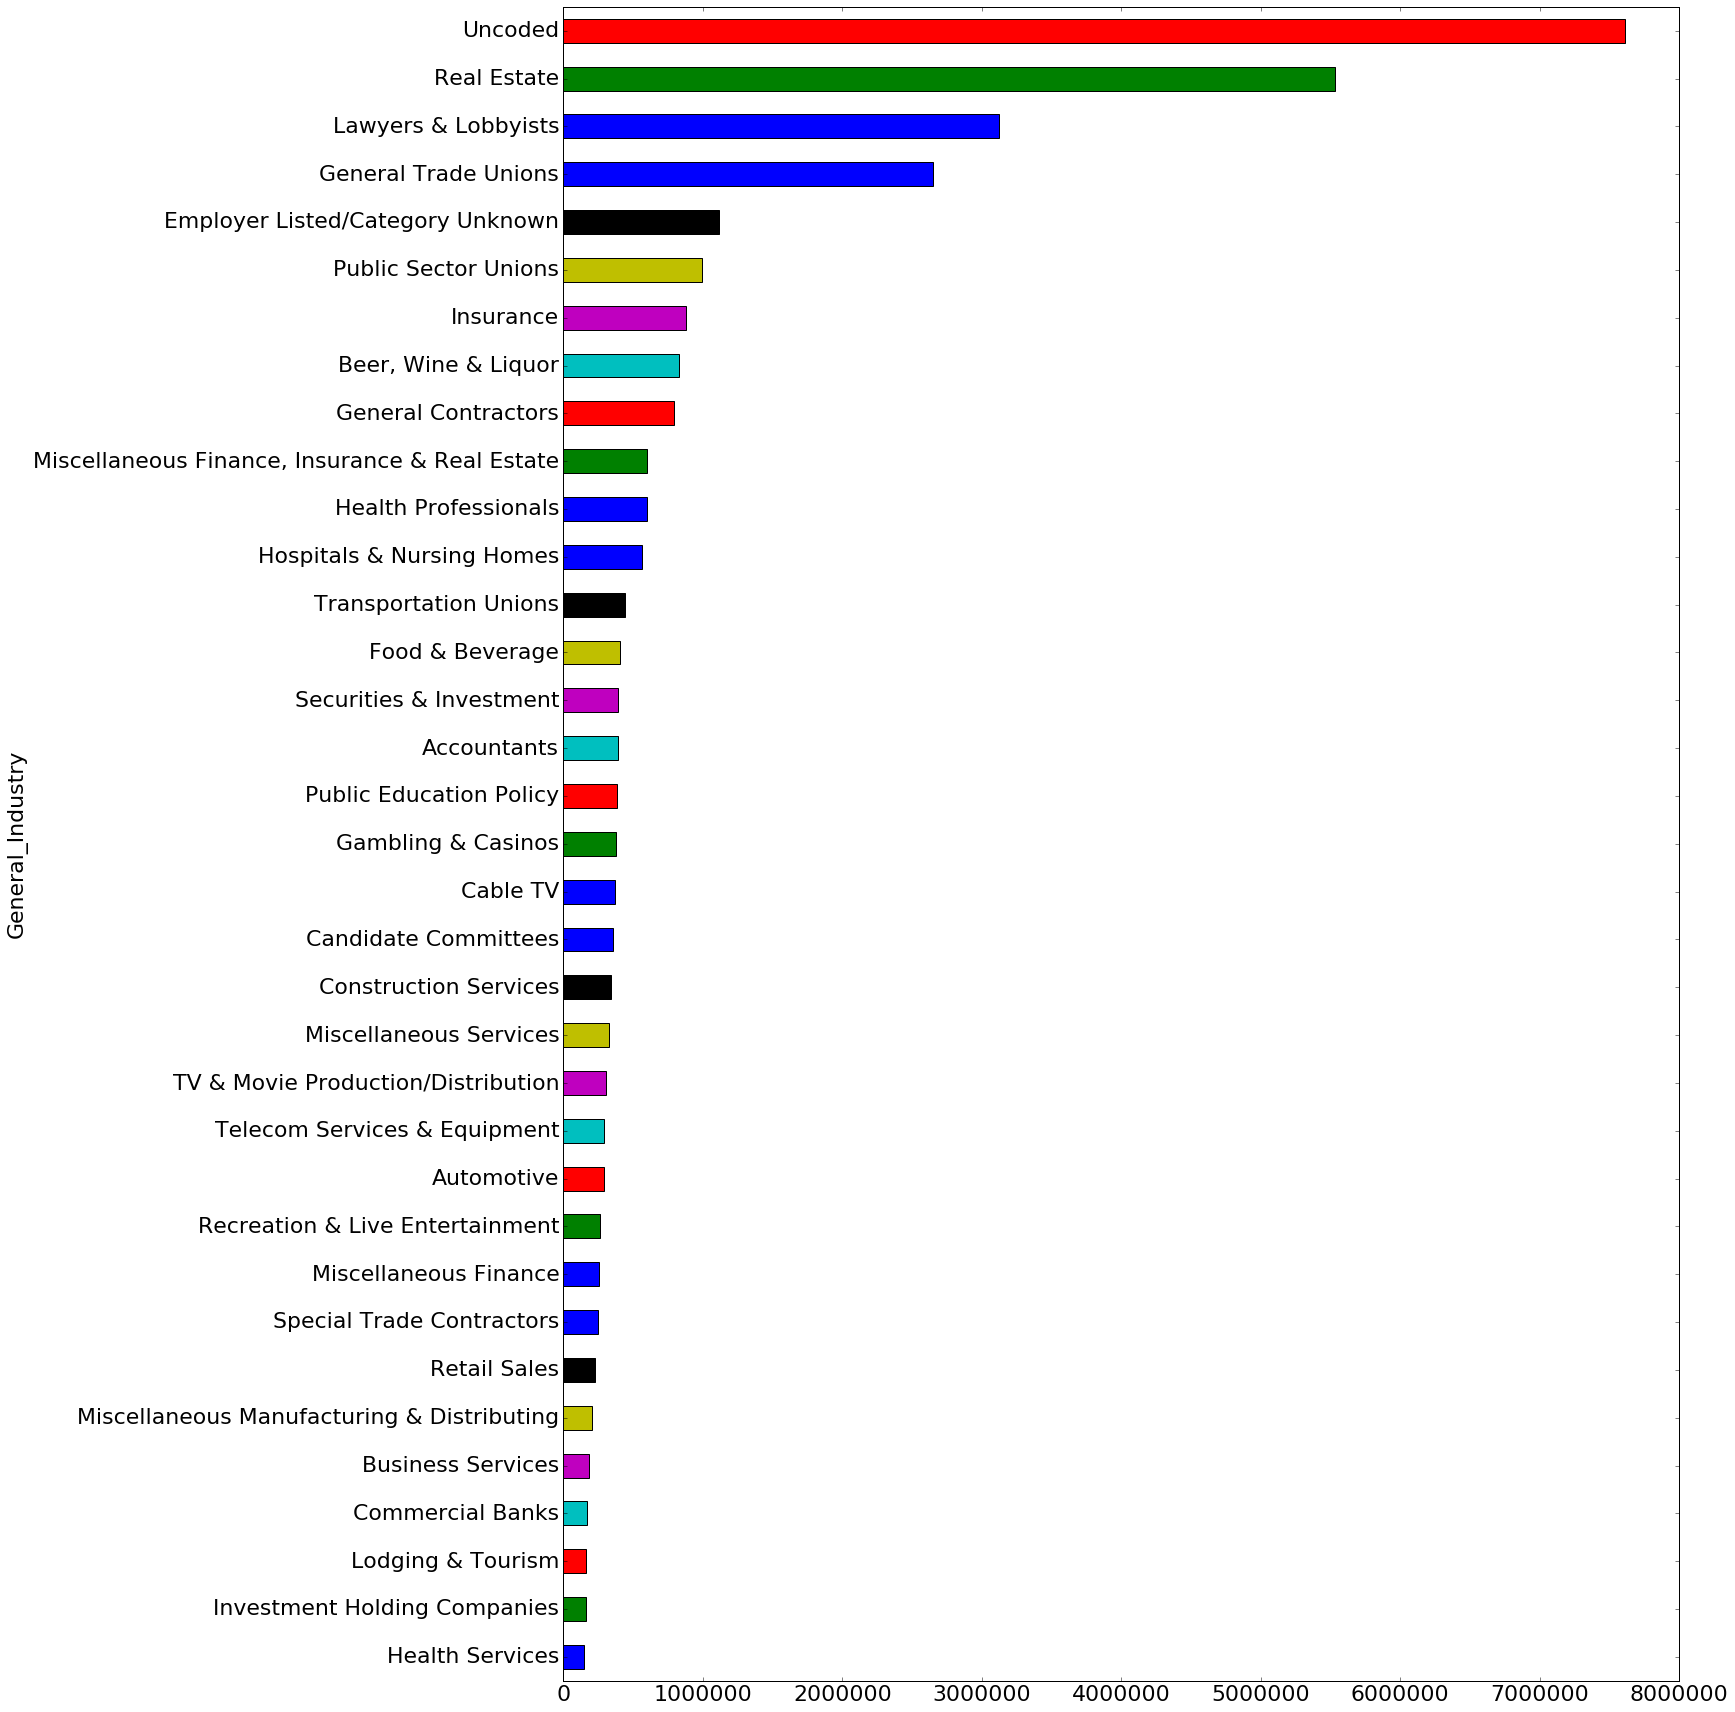

In [29]:
plt.figure(figsize=(20,30))
df_warchest.groupby('General_Industry').filter(lambda x: x['Amount_boe'].sum() > 150000)\
.groupby('General_Industry')['Amount_boe']\
.sum().sort_values()\
.plot(y='Amount_boe', x='General_Industry', kind='barh')

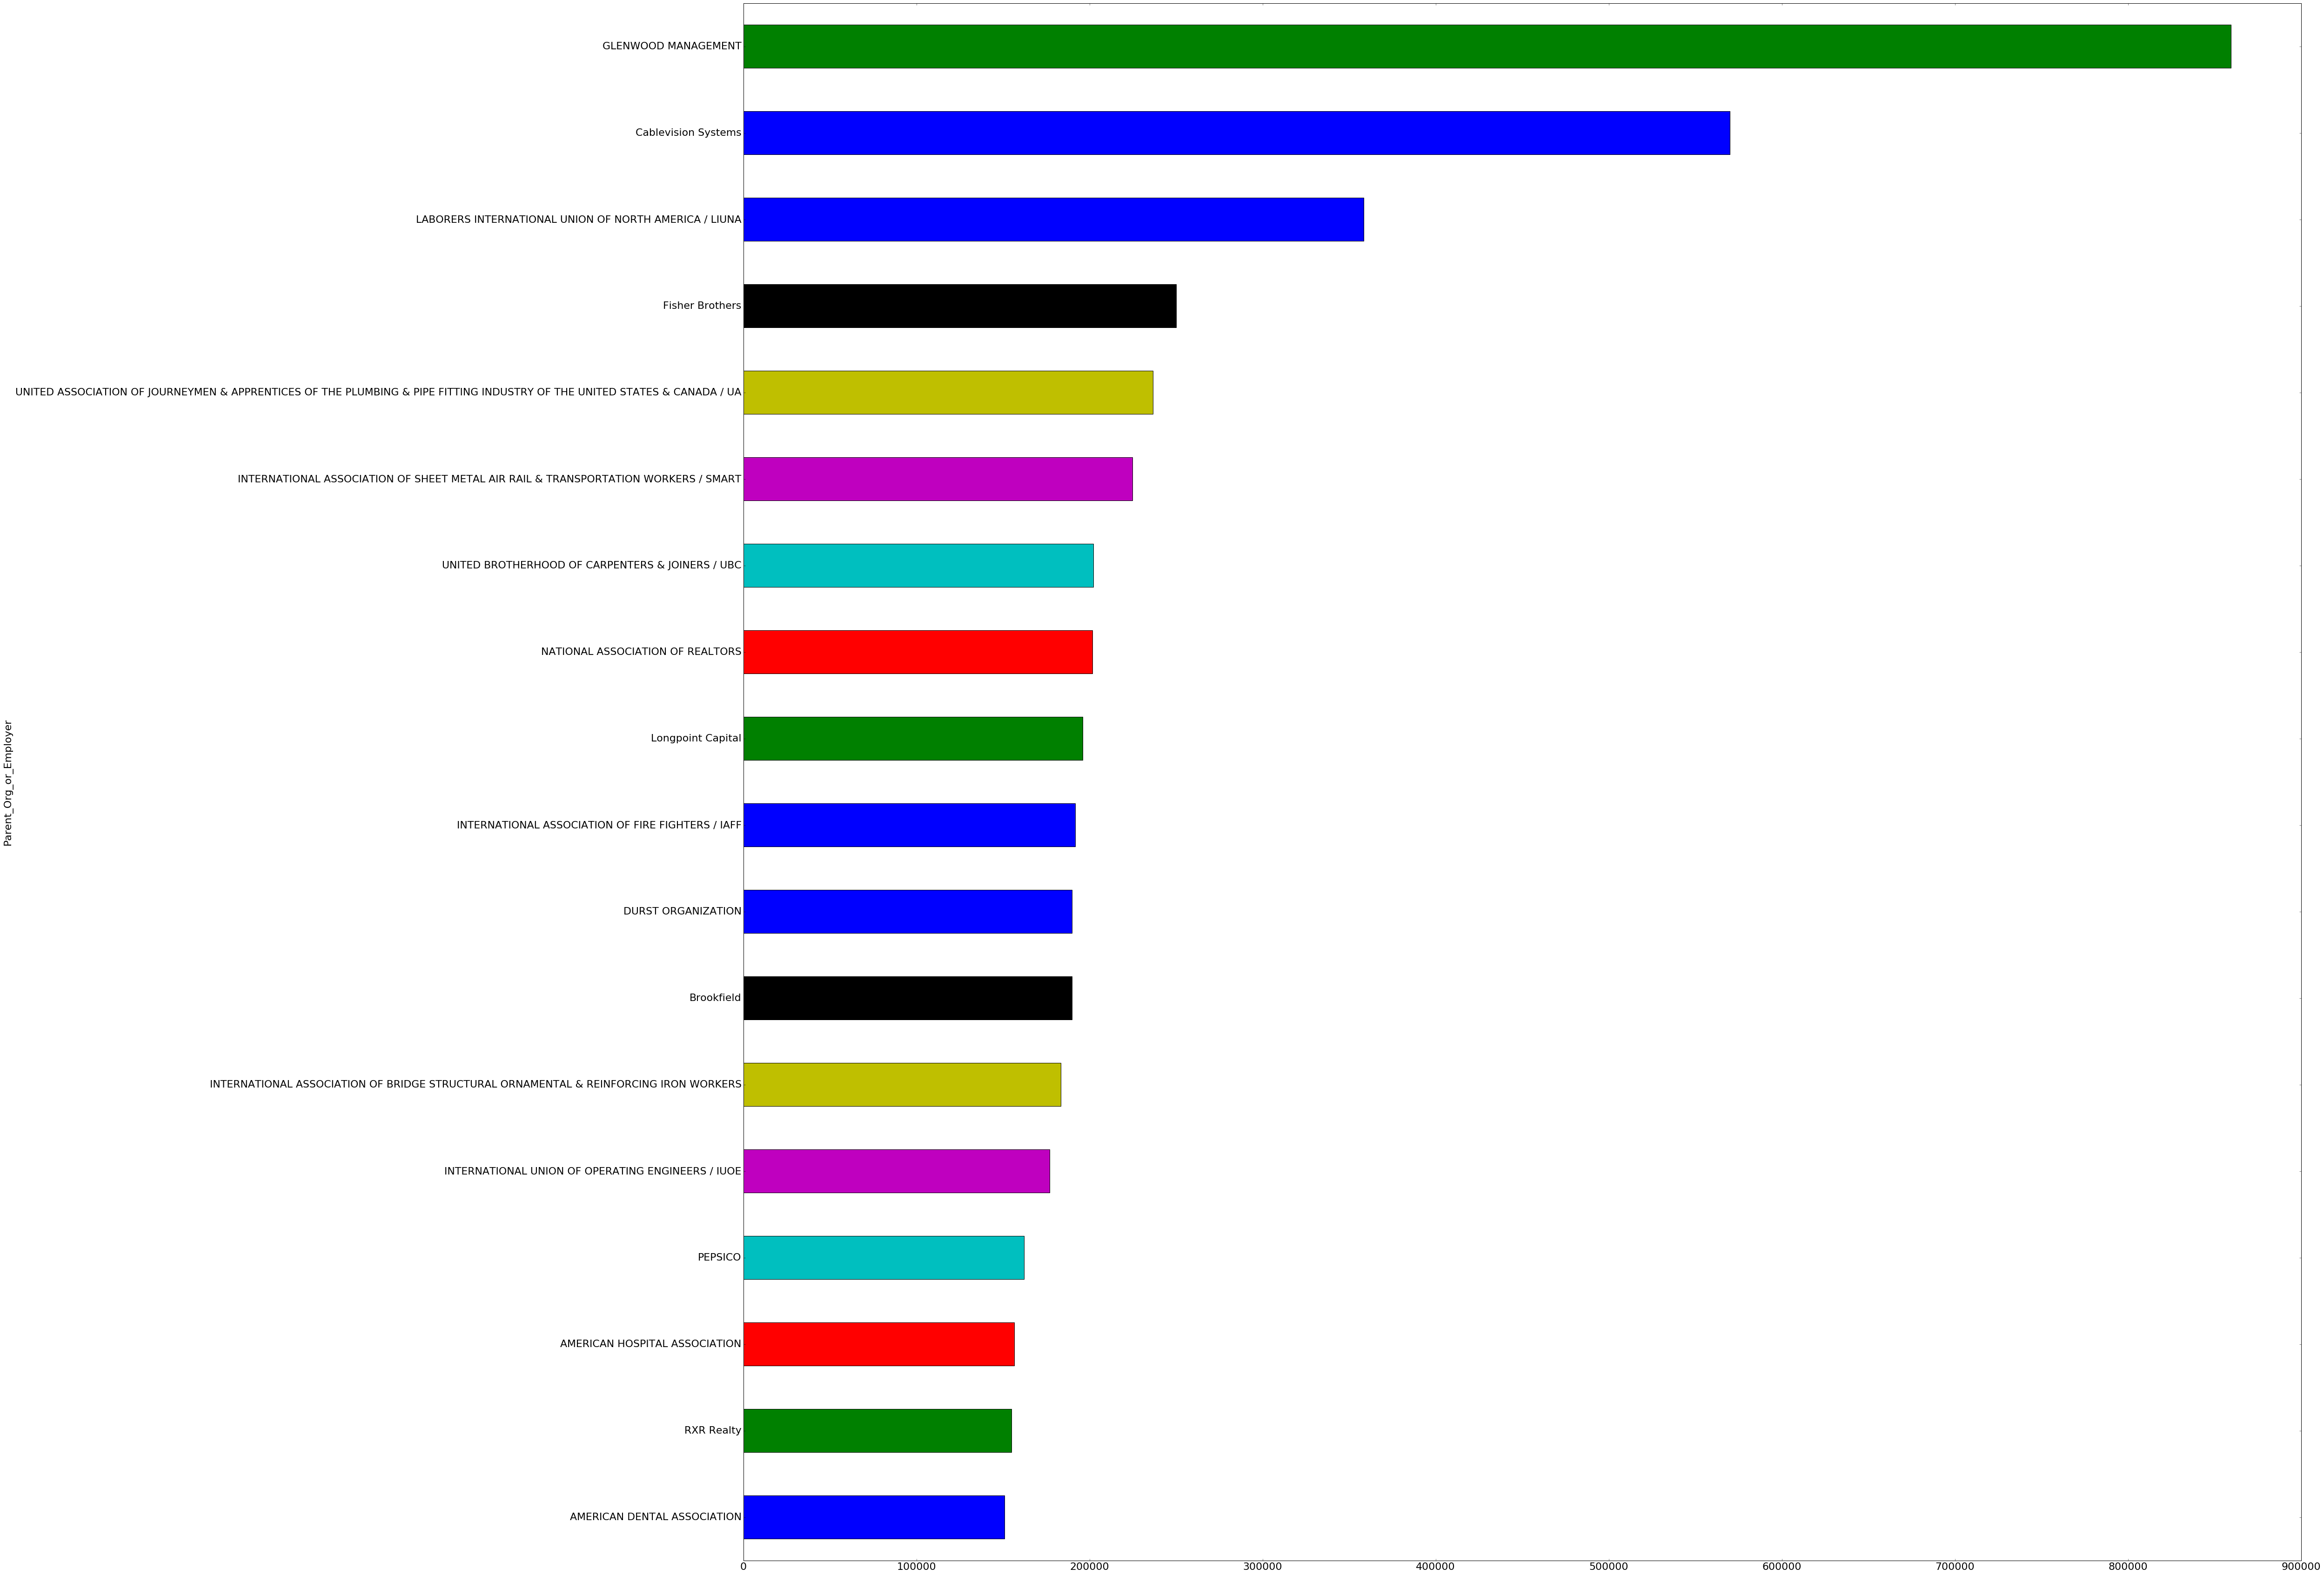

In [31]:
plt.figure(figsize=(60,60))
df_warchest.groupby('Parent_Org_or_Employer').filter(lambda x: x['Amount_boe'].sum() > 150000)\
.groupby('Parent_Org_or_Employer')['Amount_boe']\
.sum().sort_values()\
.plot(y='Amount_boe', x='Parent_Org_or_Employer', kind='barh')

In [211]:
df_warchest.groupby('Address')['Donor'].nunique().sort_values(ascending=False)

Address
1300 CLINTON SQ ROCHESTER, NY, 14604                         47
437 MADISON AVENUE NEW YORK, NY, 10022                       26
340 PEMBERWICK ROAD GREENWICH, CT, 06831                     25
348 HARRIS HILL RD WILLIAMSVILLE, NY, 14221                  19
1200 UNION TURNPIKE NEW HYDE PARK, NY, 11040                 18
1100 CLINTON SQUARE ROCHESTER, NY, 14604                     15
437 MADISON AVE NEW YORK, NY, 10022                          13
40 WEST 57TH STREET NEW YORK, NY, 10019                      13
420 LEXINGTON AVENUE NEW YORK, NY, 10170                     12
111 WASHINGTON AVENUE ALBANY, NY, 12210                      11
40 FOUNTAIN PLAZA BUFFALO, NY, 14202                         11
340 PEMBERWICK RD GREENWICH, CT, 06831                       11
1285 AVENUE OF THE AMERICAS NEW YORK, NY, 10019              10
4 EXECUTIVE BOULEVARD SUFFERN, NY, 10901                     10
110 E 59TH ST NEW YORK, NY, 10022                            9 
2775 SANDERS ROAD NORTHBROOK, IL

## Nixon Peabody, LLP is an interesting case.

They've given a total of 51,326 to Cuomo-- but their average donation is $250. Their employees give to Cuomo all on the same day(s)

In [218]:
print("\nTotal from Nixon Peabody: ", df_warchest[df_warchest['Parent_Org_or_Employer']=='Nixon Peabody LLP']['Amount_boe'].sum())
print("Average from Nixon Peabody: " ,df_warchest[df_warchest['Parent_Org_or_Employer']=='Nixon Peabody LLP']['Amount_boe'].median())
print("\nDates Nixon Peabody gave to Cuomo:")

values = df_warchest[df_warchest['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604']['Date_boe'].value_counts().keys().tolist()
counts = df_warchest[df_warchest['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604']['Date_boe'].value_counts().tolist()

i=0

for value in values:
    print("On", value, "there were", counts[i], "donations.")
    i+=1


Total from Nixon Peabody:  51326.0
Average from Nixon Peabody:  250.0

Dates Nixon Peabody gave to Cuomo:
On 12/12/2016 there were 34 donations.
On 06/26/2017 there were 13 donations.
On 12/12/2017 there were 11 donations.
On 05/13/2015 there were 1 donations.
On 07/05/2016 there were 1 donations.


## The data from Follow the Money is rich, but incomplete:

Basically, we don't have any information about 85% of Cuomo's donors, other than the name that was reported for the donation. That's terrible!

In [185]:
count, _ = df_warchest.shape

print("Percent of 'Broad Sector' unknown:", str(round(df_warchest[(df_warchest['Broad_Sector']== 'Unknown') | (df_warchest['Broad_Sector']== 'Uncoded')]\
['Donor'].count()/count, 2)*100)+"%")
print("Percent of 'General Industry' unknown:", str(round(df_warchest[(df_warchest['General_Industry']== 'Unknown') | (df_warchest['General_Industry']== 'Uncoded')]\
['Donor'].count()/count, 2)*100)+"%")
print("Percent of 'Parent Org or Employer' unknown:", str(round(df_warchest[(df_warchest['Parent_Org_or_Employer']== 'Unknown') | (df_warchest['Parent_Org_or_Employer']== 'Uncoded')]\
['Donor'].count()/count, 2)*100)+ "%")
print("Percent of 'specific business' unknown:", str(round(df_warchest[(df_warchest['Specific_Business']== 'Unknown') | (df_warchest['Specific_Business']== 'Uncoded')]\
['Donor'].count()/count, 2)*100)+"%")

Percent of 'Broad Sector' unknown: 10.0%
Percent of 'General Industry' unknown: 9.0%
Percent of 'Parent Org or Employer' unknown: 0.0%
Percent of 'specific business' unknown: 9.0%


## LLC's give disproportionately more money.

They may even be top donors, if they are categorized individually.

In [ ]:
#Who are Cuomo's top individual donors, by sum dollar amounts they have given?
#But these may not be the REAL top donors, since entities use LLCs and other mechanisms to obscure repeated donations.
df_top = df_warchest.groupby(['Donor','Address'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else list(x)).sort_values(by='Amount', ascending=False)
df_top = df_top.head(50)
_, count = df_top[df_top['Donor'].str.contains("LLC")].shape
print(count,"of Cuomo's top 50 individual donors by total amount given are LLC's")

In [ ]:
unknown_llc_number = df_warchest[(df_warchest['Donor'].str.contains('LLC')) &\
            (df_warchest['Broad_Sector']=='Unknown')&\
            (df_warchest['General_Industry']=='Unknown')&\
            (df_warchest['Specific_Business']=='Unknown')&\
            (df_warchest['Parent_Org_or_Employer']=='Unknown')]\
            ['Donor'].nunique()
print(unknown_llc_number)
print(df_warchest[df_warchest['Donor'].str.contains("LLC")]['Donor'].nunique())

## I'm going to cross-reference the list of Cuomo donor LLCs with a nyc-db to see if there are any matches.

In [ ]:
llc_list = df_warchest[(df_warchest['Donor'].str.contains('LLC')) &\
            (df_warchest['Broad_Sector']=='Unknown')&\
            (df_warchest['General_Industry']=='Unknown')&\
            (df_warchest['Specific_Business']=='Unknown')&\
            (df_warchest['Parent_Org_or_Employer']=='Unknown')]

#Here I checked the LLC names against the LLCs listed in DOBJOBS

llc_list.columns = [c.lower() for c in llc_list.columns] #postgres doesn't like capitals or spaces

from sqlalchemy import create_engine
engine = create_engine('postgresql://GeorgiaKromrei@localhost:5432/housing_data_analysis')

llc_list.to_sql("cuomo_llc_list", engine, if_exists="replace")
print("I'm loading", llc_list['donor'].nunique(), "unique LLC names into nyc-db for cross-referencing.")

## So I can answer the question: how many landlords used their shell LLC's for managing buildings, and also for donating to Cuomo?

I start by running the cuomo_llc_list.csv file through nyc-db's dobjobs table, to find exact matches-- this will be a "minimum" number. I find 132 unique LLCs that are both Cuomo donors and landlord LLCs.

In [ ]:
#These are the LLC's I get by matching directly in SQL.

df_llc=pd.read_csv('cuomo_llc_list.csv')
df_llc['ownersphone']=df_llc['ownersphone'].astype(str)
df_llc['ownersbusinessname'].nunique()

## But for a more exhaustive list, I'm going to need a list of all the LLC's in New York City.

That looks like about 175,000 unique LLCs. I'm going to match them up to the Cuomo LLC's.
I run the following query on my local copy of nyc-db to get all of the LLC's from DOBJOBS in New York:

```CREATE TABLE nyc_llc AS SELECT ownersbusinessname, bbl, address FROM dobjobs WHERE ownersbusinessname LIKE('%LLC%') GROUP BY ownersbusinessname, bbl, address                                                                 ;
SELECT 175564
```

In [ ]:
#If I use Python, I get a few more

nyc_llc = pd.read_csv('nyc_llc.csv')
nyc_llc['businessname_nollc'] = nyc_llc['ownersbusinessname'].str.upper().str.replace(r',? LLC.*','')
llc_list['donorname_nollc'] = llc_list['donor'].str.replace(r',? LLC.*','')

unique = llc_list[llc_list['donorname_nollc'].isin(nyc_llc['businessname_nollc'])]['donor'].nunique()

print("There are", unique, '''unique LLC's in NYC-DB who have given to Cuomo's campaign that were unidentified by\
either Follow the Money or the Board of Elections.''')

## I want more granular information on each LLC, how much they've given to Cuomo and when. 

So I won't just check to see if they match to some LLC in Cuomo's donor list: but confirm exactly which one(s) they match.

In [ ]:
llc_list = llc_list.merge(nyc_llc, right_on='businessname_nollc', left_on='donorname_nollc', how='left')
llc_list.drop_duplicates('check no.', keep='first', inplace=True)
llc_list.ownername = llc_list.ownername.str.upper().str.replace("ESPOISTO", "ESPOSITO")\
                                        .str.replace("EDWARD KAMIN", "EDWARD KAMINSKY")\
                                        .str.replace("EDWARD KAMINSKI", "EDWARD KAMINSKY")\
                                        .str.replace("TIVADAR MARCOVICI", "TIVADAR MARCOVICCI")\
                                        .str.replace("EDWARD KAMINSKYSKI", "EDWARD KAMINSKY")\
                                        .str.replace("EDWARD KAMINSKYSKY", "EDWARD KAMINSKY")\
                                        .str.replace("JOHNATHAN", "JONATHAN")\
                                        .str.replace("PETRACCA LESTER", "LESTER PETRACCA")\
                                        .str.replace("LOIS ESPOSITO", "LOUIS ESPOSITO")\
                                        .str.replace("LEONARD LITWIM", "LEONARD LITWIN")
                        


dumb_landlords = llc_list.groupby(['ownername'], as_index=False)\
    .agg(lambda x : x.sum() if x.dtype=='float64' else set(x))

In [ ]:
dumb_landlords.rename(columns={'ownername': 'dobjobs_ownername',
                               'address_x': 'cuomo_donor_address',
                               'address_y': 'dobjobs_address',
                                  'amount': 'donation_total',
                      'ownersbusinessname': 'dobjobs_ownersbusinessname',
                             'ownersphone': 'dobjobs_ownersphone'}, inplace=True)

## Landlords who use shell LLC's to hide from their tenants, and also to donate to Cuomo. Let's see who uses the most different LLC's:

In [ ]:
pd.set_option('display.max_rows', None)
s = dumb_landlords.donor.str.len().sort_values(ascending=False).index
dumb_landlords.reindex(s).head(50)

*Edward Kaminsky*
- a luxury real estate agent. Is he related to senator Todd Kaminsky?

*Jonathan Resnick*
- member of REBNY, who used 7 different LLC's to contribute to Cuomo
- for a total of $20,000$ all on the same day: November 16, 2017.
- The LLC's were all totally different, but registered to the same address. The donations were for $2,500 each.

*Louis Esposito* used 5 different LLC's to donate 212,500 to Cuomo.
- He is a lobbyist with Durst, according to Little Sis: https://littlesis.org/org/68088-Durst_Organization_Inc
- Durst is a member of REBNY.

*Leonard Litwin* (deceased) and *Charles Dorego* are both executives at *Glenwood Management*, Cuomo's biggest single donor. All together they've donated more than 1/2 million to Cuomo.

*Jorge Madruga* is ceo of MADDD Equities and has also given to Marco Rubio

*Exact Capital* gave 50,000 to Cuomo on January 9. Politico reported, Real Deal summarized: https://therealdeal.com/2017/01/23/cuomo-raises-4-4m-with-help-of-real-estate-donors/

In [ ]:
#Scott Alper, CEO of Witkoff Group, gave 50,000 in 2017

IFrame("https://littlesis.org/maps/2861-cuomo-rebny-map/embedded/v2", width=700, height=600)

In [ ]:


dumb_landlords.sort_values('amount_boe', ascending=False)

In [ ]:
to_merge = llc_list[['donor', 'ownername','ownersphone']].drop_duplicates('donor', keep='first')

df_new = df_warchest.merge(to_merge, right_on='donor', left_on='Donor', how='left')
df_new.drop(columns=['Donor'],inplace=True)

In [ ]:
df_new

# Next step: connect entities to industry.

## Plan:

Working with this data may be more like a war of attrition, with various passes matching the addresses or donor names to companies, 1-to-1.

Passes:

1. NYC-DB -- since I know real estate is such a significant portion of investors in Cuomo, start with NYCDB.
2. Officers -- Find those donor names matching officer names registered with OpenCorporates.
    a. What about common names -- should I limit jurisdiction to New York?
3. Registered addresses -- Find those addresses that match with registered addresses on OpenCorporates

## I'd like to find the rest of the LLC's: the ones that weren't in nyc-db. I turn to OpenCorporates' API.

In [ ]:
llc_addresses = llc_list[llc_list['ownersbusinessname'].isnull()]['address_x'].unique()
llc_names = llc_list[llc_list['ownersbusinessname'].isnull()]['donor'].unique()

In [ ]:
def get_company_names():
    oc_list = []
    for address in llc_addresses:
        oc_dict = {}
        donor = "&registered_address=" + str(address.replace(",","+").replace(" ","+"))
        base_url= "https://api.opencorporates.com/v0.4/companies/search?q="
        api_token= "&api_token=BSSwhXpP7xJ5couOddoY"
        response = requests.get(base_url+donor+api_token)
        data = json.loads(response.content)
        if len(data['results']['companies'])==1:
            for company in data['results']['companies']:
                if not company['company']['inactive']:
                    oc_dict['donor_address'] = address
                    oc_dict['company_name'] = company['company']['name']
                    oc_dict['company_type'] = company['company']['company_type']
            oc_list.append(oc_dict)
            print(oc_dict)
    return oc_list


In [ ]:
OC_names = get_company_names()

## Some summary statistics and information on Cuomo's LLC's.

- What percent of donations count are they?
- What percent of the total donations dollar amount are they?
- Do they give more or less than Cuomo's average donor?

In [ ]:
rows, _ = df_warchest[df_warchest['Donor'].str.contains("LLC",na=False)].shape
total_rows, _ = df_warchest.shape
print(rows, "or", round(rows/total_rows * 100, 2), "% of donations are from LLCs.")
df_llc = df_warchest[df_warchest['Donor'].str.contains("LLC",na=False)]
df_not_llc = df_warchest[~df_warchest['Donor'].str.contains("LLC",na=False)]
print("The total given by LLCs is:", '${:,.2f}'.format(df_llc['Amount_boe'].sum()))
print("Which is", round(df_llc['Amount_boe'].sum()/df_warchest['Amount_boe'].sum()*100, 2), "% of the total dollar amount.")
unique, _ = df_llc.groupby("Address").first().shape
print("There are", unique, "unique LLCs in the past 8 years of campaign contributions.")
avg_donation = df_not_llc['Amount_boe'].median()
llc_av_donation = df_llc['Amount_boe'].median()
print("Cuomo's donors give an average of", '${:,.2f}'.format(avg_donation), "while LLCs give an average of", '${:,.2f}'.format(llc_av_donation))

In [ ]:
df_warchest[~df_warchest.Donor.duplicated(keep='first')]['Donor'].to_frame().to_csv('unique_donors.csv', header=False, index=False)

# Once I have all of the company information from Orbis, I need to read in each of the files and concatenate them into a Pandas dataframe

Glob does this nicely, basically you can do unix-style filename syntax so something like \*.txt grabs all of the files in the folder that have the file extension .txt.

In [ ]:
import glob
allFiles = glob.glob("*.txt")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0, encoding='utf-16')
    list_.append(df)
frame = pd.concat(list_)

## Unfortunately Orbis puts repeated information (like telephone numbers, etc.) on different rows, which is not what I want.

I want them in a list, all in one cell, with one row per company.
So I group by 'Mark', since there is only one for each company. Then I take all of the different DM Fulll names and put them in a list, reset the index, and set 'Mark' as the index.
Finally, I join the lists of DMs back onto the original dataset.

In [ ]:
frame['Mark']=frame['Mark'].fillna(method='ffill')
frame['DM Full name']=frame['DM Full name'].astype('str')
df_DMs = frame.groupby('Mark')['DM Full name'].apply(', '.join).reset_index().set_index('Mark')
df_DMs.columns = df_DMs.columns.get_level_values(0)
df_DMs = df_DMs.reset_index()
frame = frame[pd.notnull(frame['Company name'])]
frame= frame.reset_index()
frame = frame.join(df_DMs,rsuffix="KEEP")

In [ ]:
naics_df = pd.read_csv('2017_NAICS_Descriptions.csv')
df = pd.merge(frame, naics_df, left_on='NAICS 2017 Core code (4 digits)',right_on='Code',how='left')

In [ ]:
df_warchest['Donor']=df_warchest['Donor'].astype(str)
df['Company name']=df['Company name'].astype(str)
df = df.sort_values(by='Company name')
df_warchest = df_warchest.sort_values(by='Donor')

In [ ]:
#BE CAREFUL to only run this once
import jellyfish

def get_closest_match(x, list_strings):
    best_match = None
    highest_jw = 0
    for current_string in list_strings:
        current_score = jellyfish.jaro_winkler(x, current_string)

        if(current_score > highest_jw):
            highest_jw = current_score
            best_match = current_string
    return best_match

df['Company name'] = df['Company name'].map(lambda x: get_closest_match(x, df_warchest['Donor']))

In [ ]:
df

In [ ]:
merged_donors_companies= df_warchest.merge(df, how='left', right_on='Company name', left_on='Donor')

llc_networks = merged_donors_companies[merged_donors_companies['Donor'].str.contains('LLC')].groupby(['Telephone number'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else set(x))

In [ ]:
df = merged_donors_companies.groupby(['Telephone number'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else set(x))

In [ ]:
df[df['Telephone number']!= 'Credit needed'].sort_values(by='Amount',ascending=False)

In [ ]:
df['Registered Address']=df['Street, no., building etc, line 1'].map(str) + df['Street, no., building etc, line 2'].map(str)
df.columns

In [ ]:
df = df.groupby(['Registered Address'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else set(x))

In [ ]:
df.sort_values(by='Amount',ascending=False)
#df.columns

In [ ]:
llc_networks.sort_values(by='Amount',ascending=False)

In [ ]:
#Scrape PAC information from Open Secrets

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
import re

In [ ]:
df_warchest['PAC Search Name'] = df_warchest['Donor']
replace = ['INC.', '\sPOLITICAL ACTION COMMITTEE$', '\sCORP', '\s&\sCO.', '\s$', '\sASSOCIATION','NY-PAC$','PAC$','PAC,$']

pac_df = df_warchest[(df_warchest['Donor'].str.contains('PAC')) | (df_warchest['Donor'].str.contains('POLITICAL ACTION COMMITTEE'))]
pac_df['PAC Search Name'] = pac_df['PAC Search Name'].replace(to_replace=replace,value="",regex=True )
pac_uniques = pac_df.drop_duplicates('PAC Search Name',keep='first')
#driver=webdriver.Chrome()
#pac_uniques.apply(get_pac_industry_info, axis=1)
pac_uniques.reset_index()

In [ ]:
pac_list=[]
def get_pac_industry_info(row):
    driver.get('https://www.opensecrets.org/pacs/search.php')
    driver.find_element_by_class_name('textfield').send_keys(row['PAC Search Name'])
    driver.find_element_by_class_name('btn').click()
    try:
        driver.find_elements_by_tag_name('td')[0].find_element_by_tag_name('a').click()
        
    except:
        try:
            driver.find_element_by_tag_name('td').click()
        except:
            pass
    pac_dict = {}
    try:    
        left_column = driver.find_element_by_id('profileLeftColumn')
        column = left_column.text.split('\n')
        pac_list.append(column)
    except:
        column = "Not found"
        row['PAC Info'] = column

In [ ]:
count=0
for pac in pac_list:
    if pac=='Not found':
        pass
    else:
        count+=1
print(count)

In [ ]:
['href']

In [ ]:
df = pd.read_csv("FollowTheMoneyDownload20180705(010706).csv")

In [ ]:
new = df.merge(df_warchest, left_on='Original_Name', right_on='Donor', how='inner')

In [ ]:
new

In [ ]:
df.shape

In [ ]:
df_warchest.shape